# PEAS Meal Networks Analysis

# Set up
This notebook requires several modules. If you do not have them run the cell below, else skip

## Load in the necessary libraries/packages/modules

In [4]:
! pip install  python-louvain --user



  Created wheel for python-louvain: filename=python_louvain-0.13-cp37-none-any.whl size=9223 sha256=dc850a8940fe6c2667d973910ba28a4d53409404dfb493dc7910167f1dedfc92
  Stored in directory: /home/jovyan/.cache/pip/wheels/f9/74/a9/14f051b00dddd46d71529db15507796da13a43ee2c0bc39def
Successfully built python-louvain


In [77]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import glob
import community
import pdb

import matplotlib.pyplot as plt


from scipy import linalg
from sklearn.covariance import GraphLassoCV
from sklearn import covariance, preprocessing


In [12]:
basepath='/home/jovyan/work/data'

## Read in the data

In [13]:
file_dict={'infant': {}, 'young':{},'child':{},'mom':{}}

In [14]:
file_dict["mom"]["files"] = [x for x in glob.glob(os.path.join(basepath,'*HEI.csv')) if "Mom" in x]
file_dict["infant"]["files"] = [x for x in glob.glob(os.path.join(basepath,'*HEI.csv')) if "infant" in x]
file_dict["young"]["files"] = [x for x in glob.glob(os.path.join(basepath,'*HEI.csv')) if "young" in x]
file_dict["child"]["files"] = [x for x in glob.glob(os.path.join(basepath,'*HEI.csv')) if "child" in x]

In [15]:
file_dict

{'infant': {'files': ['/home/jovyan/work/data/DF_infant_infant_HEI.csv']},
 'young': {'files': ['/home/jovyan/work/data/DF_young_young_HEI.csv']},
 'child': {'files': ['/home/jovyan/work/data/DF_child_child_HEI.csv']},
 'mom': {'files': ['/home/jovyan/work/data/Mom_dailyhei0409_HEI.csv',
   '/home/jovyan/work/data/Mom_hei0409_HEI.csv']}}

In [16]:
data_dict={'infant': {}, 'young':{},'child':{},'mom':{}}

In [17]:
for key, value in file_dict.items():
    for dat in value['files']:
        subkey=dat.split('/')[-1].split('.')[0]
        data_dict[key][subkey]=pd.read_csv(dat,sep=',')

# Make correlations

In [78]:
child_var = ['hei_totveg','hei_greensbeans','hei_totfruit','hei_wholefruit',
     'hei_wholegrains','hei_dairy','hei_totproteins','hei_seafoodplantprot',
     'hei_refinedgrains','hei_fruitjuice','hei_SSB','chocolate_candies','candies',
     'frosting','sweet_sauce','sugar','syrups','Pudding','icecream','nondairy_treat','baked_good',
     'chips','fries','other_fried','formula_foz','cereal_oz','bbcereal_hcup','hei_sweets','hei_salty',
     'hei_vegetables','hei_proteins','hei_milk','hei_cereal']

In [80]:
mom_var=['energy','HEIX1_TOTALVEG','HEIX2_GREEN_AND_BEAN','HEIX3_TOTALFRUIT','HEIX4_WHOLEFRUIT','HEIX5_WHOLEGRAIN','HEIX6_TOTALDAIRY','HEIX7_TOTPROT','HEIX8_SEAPLANT_PROT','HEIX11_REFINEDGRAIN','HEIX12_ADDEDSUGARS','HEIX13_SATFATS','HEIX9_FATTYACID','HEIX10_SODIUM']

In [81]:
infant_var=['formula_foz', 'hei_milk', 'HEIX0_BREASTFEEDING', '% Calories from Carbohydrate', '% Calories from Fat','% Calories from MUFA','% Calories from PUFA','% Calories from Protein','% Calories from SFA']

In [171]:
vars_of_interest = {'mom': mom_var, 'child':child_var , 'young':infant_var , 'infant': infant_var}

In [174]:
def scaley(X):
    X=X.loc[:, (X != 0).any(axis=0)]
    X = X.values.astype('float64')
    myScaler = preprocessing.StandardScaler()
    X = myScaler.fit_transform(X)
    emp_cov = covariance.empirical_covariance(X)
    shrunk_cov = covariance.shrunk_covariance(emp_cov, shrinkage=0.9) # Set shrinkage closer to 1 for poorly-conditioned data
    alphaRange = 10.0 ** np.arange(-8,0) # 1e-7 to 1e-1 by order of magnitude
    for alpha in alphaRange:
        try: 
            graphCov = covariance.graph_lasso(shrunk_cov, alpha)
            print("Calculated graph-lasso covariance matrix for alpha=%s"%alpha)
        except FloatingPointError:
            print("Failed at alpha=%s"%alpha)
    return(X)

In [176]:
corr_dict={'infant': {}, 'young':{},'child':{},'mom':{}}
for key, value in data_dict.items():
    print(key)
    for k, data in value.items():
        Y=data[vars_of_interest[key]]
        X=scaley(Y)
        lw_cov_, _ =ledoit_wolf(X)
        corr_dict[key]['lw_cov_%s'%k]=lw_cov_
        corr_dict[key]['lw_prec_%s'%k]=linalg.inv(lw_cov_)

infant
Calculated graph-lasso covariance matrix for alpha=1e-08
Calculated graph-lasso covariance matrix for alpha=1e-07
Calculated graph-lasso covariance matrix for alpha=1e-06
Calculated graph-lasso covariance matrix for alpha=1e-05
Calculated graph-lasso covariance matrix for alpha=0.0001
Calculated graph-lasso covariance matrix for alpha=0.001
Calculated graph-lasso covariance matrix for alpha=0.01
Calculated graph-lasso covariance matrix for alpha=0.1
young
Calculated graph-lasso covariance matrix for alpha=1e-08
Calculated graph-lasso covariance matrix for alpha=1e-07
Calculated graph-lasso covariance matrix for alpha=1e-06
Calculated graph-lasso covariance matrix for alpha=1e-05
Calculated graph-lasso covariance matrix for alpha=0.0001
Calculated graph-lasso covariance matrix for alpha=0.001
Calculated graph-lasso covariance matrix for alpha=0.01
Calculated graph-lasso covariance matrix for alpha=0.1
child
Calculated graph-lasso covariance matrix for alpha=1e-08
Calculated graph

After normalizing your input data, the eigenvalues of your empirical covariance matrix still span a relatively large range of about [0-8]. Shrinking this using the sklearn.covariance.shrunk_covariance() function can bring it into a more computationally acceptable range (from what I've read, [0,1] is ideal but slgihtly larger ranges also appear to work).  
https://stats.stackexchange.com/questions/172911/graphical-lasso-numerical-problem-not-spd-matrix-result

In [196]:
def plotz(dicti):
    #covs are a list of plots
    n=len(list(dicti.keys()))*2
    # Plot the results
    plt.figure(figsize=(10, n+2))
    plt.subplots_adjust(left=0.02, right=0.98)
    # plot the covariances

    i=0
    for key, value in dicti.items(): 
        for k,v in value.items():
            if "lw_cov" in k:
                print(k)
                vmax = v.max()
                plt.subplot(2, 5, i + 1)
                plt.imshow(v, interpolation='nearest', vmin=-vmax, vmax=vmax,
                           cmap=plt.cm.RdBu_r)
                plt.xticks(())
                plt.yticks(())
                plt.title('%s \n covariance' %k)


                i=i+1

    # plot the precisions
    i=0
    for key, value in dicti.items(): 
        for k,v in value.items():
            if "lw_prec" in k:
                vmax = .9 * v.max()
                ax = plt.subplot(2, 5, i + 6)
                plt.imshow(np.ma.masked_equal(v, 0),
                           interpolation='nearest', vmin=-vmax, vmax=vmax,
                           cmap=plt.cm.RdBu_r)
                plt.xticks(())
                plt.yticks(())
                plt.title('%s \n precision' % k)
                i=i+1
                print(i)
                if hasattr(ax, 'set_facecolor'):
                    ax.set_facecolor('.7')
                else:
                    ax.set_axis_bgcolor('.7')
    plt.show()

lw_cov_DF_infant_infant_HEI
lw_cov_DF_young_young_HEI
lw_cov_DF_child_child_HEI
lw_cov_Mom_dailyhei0409_HEI
lw_cov_Mom_hei0409_HEI
1
2
3
4
5


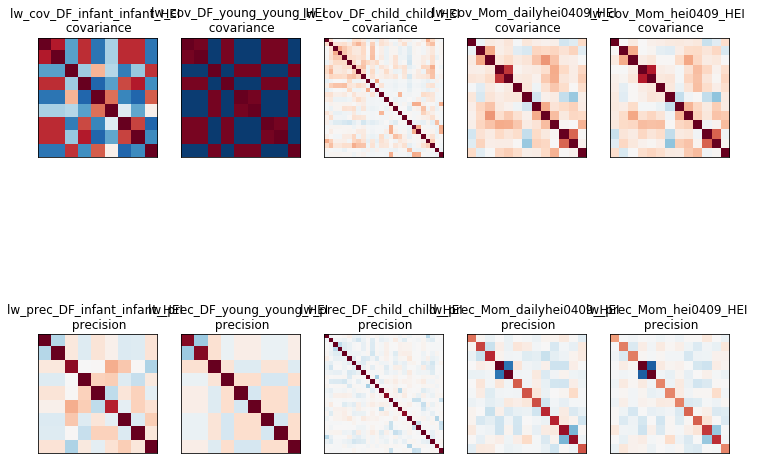

In [197]:
plotz(corr_dict)

Looks like the graphical lasso is not the way to go, going to default to LW

## This is making a dictionary with the food options for networkX

In [ ]:
labels = data.index
labels_dict = {}
n=0
for item in labels:
    labels_dict[n]=item
    n=n+1

# Creating the graph object

In [ ]:
G = nx.from_numpy_matrix(data.values)

## Check edges

In [ ]:
G.edges(data=True)

## Set node attributes with the food data

In [ ]:
nx.set_node_attributes(G,labels_dict,'food')

## Check nodes

In [ ]:
G.nodes(data=True)

# Make a nice graph
The output you made can be made with edge weights using the 'spring' option 

In [ ]:
def create_corr_network(G, *argv):
    # creates a list for edges and for the weights
    # G must be a networkx graph object
    # Style = Choice of graph = circle, spring, spectral
    
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    
    #positions
    if len(argv) != 0:
        for arg in argv:
            print("Making %s graph"%arg)
            if arg == "circle":
                positions=nx.circular_layout(G)
            elif arg == "spring":
                positions=nx.spring_layout(G)
            elif arg == "spectral":
            
                positions=nx.spectral_layout(G)
    else:
        positions=nx.circular_layout(G)

    #Figure size
    plt.figure(figsize=(15,15))

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color='#DA70D6',
                           node_size=500,alpha=0.8)
    labels=dict(G.nodes(data=True))
    #Styling for labels
    
    
    nx.draw_networkx_labels(G,positions,labels, font_size=8, 
                            font_family='sans-serif')
        
    #draws the edges
    vmin = min(weights)
    vmax = max(weights)
    
    w=np.array(weights)*10
    nx.draw_networkx_edges(G, positions, edge_list=edges, style='solid', width= w, edge_color= weights, 
                           edge_cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
    
    # displays the graph without axis
    plt.axis('off')
    #saves image
    #plt.savefig("part1.png", format="PNG")
    sm = plt.cm.ScalarMappable(cmap=plt.cm.seismic, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)
    plt.show() 

In [ ]:
create_corr_network(G, 'spring')

# Next steps
If you have a regular structure for directories I can write a function that will pick up the csv files and run all of this at once. This is a general tutorial. As we get closer to publication we can make the graphs pretty. The next things to consider are graph metrics. I recommend modularity, participation coefficient, and clustering coefficient. 